In [1]:
import pdb
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from PIL import Image
import numpy as np




from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T



import timeit
import random
import math
import time
import copy
import os
#import cv2

In [2]:
class myreScale(object):
    """Rescales the input PIL.Image to the given 'size'.
    'size' will be the size of the smaller edge.
    For example, if height > width, then image will be
    rescaled to (size * height / width, size)
    size: size of the smaller edge
    interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img):

        return img.resize((self.size, self.size), self.interpolation)


class CenterCrop(object):
    """Crops the given PIL.Image at the center to have a region of
    the given size. size can be a tuple (target_height, target_width)
    or an integer, in which case the target will be of a square shape (size, size)
    """

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, img):
        w, h = img.size
        th, tw = self.size
        x1 = int(round((w - tw) / 2.))
        y1 = int(round((h - th) / 2.))
        return img.crop((x1, y1, x1 + tw, y1 + th))

class myRandomSizedCrop(object):
    """Random crop the given PIL.Image to a random size of (0.08 to 1.0) of the original size
    and and a random aspect ratio of 3/4 to 4/3 of the original aspect ratio
    This is popularly used to train the Inception networks
    size: size of the smaller edge
    interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img):      

        #pdb.set_trace()
        temp1 = img.size[0] - self.size[0]
        temp2 = img.size[1] - self.size[1]
        
        x1 = random.randint(0,temp1)
        y1 = random.randint(0,temp2)

        w = self.size
        h = self.size  
        return img.crop((x1, y1, x1 + w, y1 + h))
        

def myRandomHorizontalFlip(img,rand):

    if rand < 0.5:
        if isinstance(img, np.ndarray):
             return np.fliplr(img).copy()

        return img.transpose(Image.FLIP_LEFT_RIGHT)
    return img

class myToTensor(object):
    """Converts a PIL.Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """

    def __call__(self, pic,rand):
        if isinstance(pic, np.ndarray):
            # handle numpy array
            img = torch.from_numpy(pic.transpose((2, 0, 1)))
            # backard compability
            return img.float().div(255)
        # handle PIL Image
        if pic.mode == 'I':
            img = torch.from_numpy(np.array(pic, np.int32, copy=False))
        elif pic.mode == 'I;16':
            img = torch.from_numpy(np.array(pic, np.int16, copy=False))
        else:
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
        # PIL image mode: 1, L, P, I, F, RGB, YCbCr, RGBA, CMYK
        if pic.mode == 'YCbCr':
            nchannel = 3
        elif pic.mode == 'I;16':
            nchannel = 1
        else:
            nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)
        # put it from HWC to CHW format
        # yikes, this transpose takes 80% of the loading time/CPU
        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        if isinstance(img, torch.ByteTensor):
            return img.float().div(255)
        else:
            return img

In [3]:
import torch.utils.data as data
import numpy as np
from PIL import Image
import os
import os.path
from IPython.core.debugger import set_trace
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)



def find_classes(dir):

    classes = [ int(d[:-19]) for d in os.listdir(dir) if(len(d)>10)]
    
    classes = sorted(set(classes))
    
    class_to_idx = {classes[i]: i for i in range(len(classes))}

    idx_to_class = {i: classes[i] for i in range(len(classes))}
    
    return classes, class_to_idx, idx_to_class


def make_dataset(dir,randomList,split,junk,class_to_idx):

    train_datas = []
    train_labels = []
    train_cams = []
    val_datas = []
    val_labels = []
    val_cams = []

    file_list = sorted(os.listdir(dir))
    train_vali_split_point = int(len(randomList)*split)
    
    for i in randomList[:train_vali_split_point]:
        fname = file_list[i]
        if is_image_file(fname) and fname not in junk:
            #path = os.path.join(dir, fname)
            label = class_to_idx[ int(fname[:-19]) ] 
            cam = int(fname[-17:-16])
            train_datas.append(fname)
            train_labels.append(label)
            train_cams.append(cam)
            
    for i in randomList[train_vali_split_point+1:]:
        fname = file_list[i]
        if is_image_file(fname) and fname not in junk:
            #path = os.path.join(dir, fname)
            label = class_to_idx[ int(fname[:-19]) ] 
            cam = int(fname[-17:-16])
            val_datas.append(fname)
            val_labels.append(label)
            val_cams.append(cam)


    return train_datas,train_labels,train_cams, val_datas, val_labels, val_cams

def make_test_dataset(dir,class_to_idx):

    datas = []
    labels = []
    cams = []

    for fname in sorted(os.listdir(dir)):

        if is_image_file(fname):
            path = os.path.join(dir, fname)
            label = class_to_idx[ int(fname[:-19]) ] 
            cam = int(fname[-17:-16])

            datas.append(path)
            labels.append(label)
            cams.append(cam)

    return datas, labels, cams

 



def default_loader(path):
    return Image.open(path).convert('RGB')
def numpy_loader(path):
    return np.load(path)

In [4]:
class poseMarket(data.Dataset):
    """From the MNIST Dataset it generates triplet samples
    note: a triplet is composed by a pair of matching images and one of
    different class.
    """
    
    def __init__(self, root, root2, randomList, names,split=0.8,n_pairs=800, train=1, transform=None, target_transform=None,
                 loader=default_loader ):
        
        self.classes,self.class_to_idx, self.idx_to_class = find_classes(root)
        
        self.nameList = self.getNameList(names)
        
        self.train_datas, self.train_labels, self.train_cams, self.val_datas, \
            self.val_labels, self.val_cams = make_dataset(root,randomList,split,self.nameList,self.class_to_idx)
        
        if len(self.train_datas) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

        self.root = root
        self.root2 = root2
        
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.train = train
        self.split = split
        self.n_pairs =n_pairs

        if self.train:
            self.train_pairs = self.get_pairs(self.train_labels)
        else:
            self.val_pairs = self.get_pairs(self.val_labels)
            
    def getNameList(self,names):
        import scipy.io

        mat = scipy.io.loadmat(names)

        nameList =[]
        for i in range(len(mat['filelist'][0])):
            bb = mat['filelist'][0][i][0]
            dd = str(bb.tolist())
            nameList.append(dd[:-9]+'.jpg')
        return nameList
            


    def get_pairs(self,labels):
        pairs = []
        labels = np.asarray(labels)
        ulabels = np.unique(labels)
        #ulabels = self.classes
        matches, no_matches = dict(), dict()
   
        for x in ulabels:

            matches[x] = np.where(labels == x)[0]

            
        temp = np.random.choice(ulabels,self.n_pairs)

        #set_trace()
        for x in temp:
            #print(matches[x].shape[0])

            if matches[x].shape[0] < 2:
                
                idx_a, idx_b = np.random.choice(matches[x], 2)
            else:
                
                idx_a, idx_b = np.random.choice(matches[x], 2, replace=False)

            pairs.append([idx_a, idx_b])
        
        return np.array(pairs)

    def __getitem__(self, index):
        
        if self.train:
            
            t = self.train_pairs[index]
            a, b = self.train_datas[t[0]], self.train_datas[t[1]]
                        

            label = self.train_labels[t[1]]


            # doing this so that it is consistent with all other datasets
            # to return a PIL Image
            imPathA = self.root + a 
            imPathB = self.root + b 
            
            heatPath = self.root2 + 'train_heatmap/' + b[:-4] + '_heat.npy'
            maskPath = self.root2 + 'train_mask/' + b[:-4] + '_mask.png'
            
            img_a = self.loader(imPathA)
            img_b = self.loader(imPathB)
            heat = numpy_loader(heatPath)
            mask = self.loader(maskPath)

            rand = random.random()
            img_b = myRandomHorizontalFlip(img_b,rand)
            mask = myRandomHorizontalFlip(mask,rand)
            heat = myRandomHorizontalFlip(heat,rand)   
            
            

            heat = np.transpose(heat, (2,0,1))  
            heat = torch.from_numpy(heat[:18])
            
            if self.transform is not None:
                
                img_a = self.transform(img_a)
                img_b = self.transform(img_b)
                mask = self.transform(mask)

            #pdb.set_trace()
                
            return img_a, img_b, heat, mask, label
        
        else:
            
            t = self.val_pairs[index]
            a, b = self.val_datas[t[0]], self.val_datas[t[1]]


            label = self.val_labels[t[1]]


            # doing this so that it is consistent with all other datasets
            # to return a PIL Image
            imPathA = self.root + a 
            imPathB = self.root + b 
            
            heatPath = self.root2 + 'train_heatmap/' + b[:-4] + '_heat.npy'
            maskPath = self.root2 + 'train_mask/' + b[:-4] + '_mask.png'
            
            img_a = self.loader(imPathA)
            img_b = self.loader(imPathB)
            heat = numpy_loader(heatPath)
            mask = self.loader(maskPath)


            rand = random.random()
            img_b = myRandomHorizontalFlip(img_b,rand)
            mask = myRandomHorizontalFlip(mask,rand)
            heat = myRandomHorizontalFlip(heat,rand) 
            

            heat = np.transpose(heat, (2,0,1))  
            heat = torch.from_numpy(heat[:18])
            if self.transform is not None:

                img_a = self.transform(img_a)
                img_b = self.transform(img_b)
                mask = self.transform(mask)

            
            #pdb.set_trace()
                
            return img_a, img_b, heat, mask, label

    def __len__(self):
        if self.train:
            return self.train_pairs.shape[0]
        else:
            return self.val_pairs.shape[0]

In [5]:
#%debug
import random
randList = list(range(12936))
random.shuffle(randList)
market = '/home/dsp411/zhou/datasets/market/Market-1501-v15.09.15/bounding_box_train/'
names ='/home/dsp411/zhou/MYwork2/pytorch_Realtime_Multi-Person_Pose_Estimation-master/sample_image/filenames.mat'
root2 = '/home/dsp411/zhou/MYwork2/pytorch_Realtime_Multi-Person_Pose_Estimation-master/sample_image/'
trans_TEST = transforms.Compose([
        #myreScale(240),
        #myRandomSizedCrop(224),
        #T.RandomHorizontalFlip(),
        T.ToTensor()
])


"""
my_trans3 = transforms.Compose([
        myreScale(224),
        T.ToTensor(),
        T.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                          std = [ 0.229, 0.224, 0.225 ])]
        
)
"""

train_data = poseMarket(market,root2,randList,names,n_pairs=1000,transform=trans_TEST)
train_class_idx = train_data.class_to_idx
train_len = len(train_data)
loader_train = DataLoader(train_data,batch_size=5)

val_data = poseMarket(market,root2,randList,names,n_pairs=1000,train=0,transform=trans_TEST)
val_class_idx = val_data.class_to_idx
val_len = len(val_data)
loader_val = DataLoader(val_data,batch_size=5)



OSError: [Errno 2] No such file or directory: '/home/dsp411/zhou/datasets/market/Market-1501-v15.09.15/bounding_box_train/'

In [6]:
train_len

NameError: name 'train_len' is not defined

In [7]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def imshow(img):
    #img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
def imsave(PATH,img):
    #img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imsave(PATH,np.transpose(npimg, (1,2,0)))
#%debug
# show some random training images
dataiter = iter(loader_val)
imagesA, imagesB,heatMapB,maskB,labels = dataiter.next()

# print images
print(imagesA.size())

#imshow(torchvision.utils.make_grid(imagesA))
#imshow(torchvision.utils.make_grid(mask))
imshow(torchvision.utils.make_grid(heatMapB[:,17:18,:,:]))

print(labels)


"""
reverse_trans3 = transforms.Compose([
        reNormalize(mean = [ 0.485, 0.456, 0.406 ],
                          std = [ 0.229, 0.224, 0.225 ])]
        
)

t_img,t_l = val_data[1:10]
img= reverse_trans3( t_img )
imshow(torchvision.utils.make_grid(img))
"""

NameError: name 'loader_val' is not defined

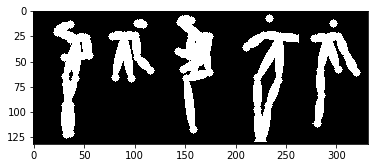

In [8]:
imshow(torchvision.utils.make_grid(maskB))

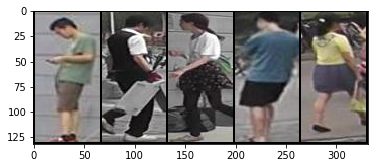

In [9]:
imshow(torchvision.utils.make_grid(imagesB))

In [10]:
#%debug
"""
ImgForder = '/home/dsp411/zhou/datasets/market/Market-1501-v15.09.15/bounding_box_train/'
HeatmapForder = './sample_image/train_heatmap/'
MaskForder = './sample_image/train_mask/'
DilateForder = './sample_image/train_dialte/'
dotForder = './sample_image/train_dot/'

fileList1 = sorted(os.listdir(ImgForder))
fileList2 = sorted(os.listdir(HeatmapForder))
fileList3 = sorted(os.listdir(MaskForder))
fileList4 = sorted(os.listdir(DilateForder))
fileList5 = sorted(os.listdir(dotForder))


for i in range(12936):
    print(i)
    image = default_loader( ImgForder+fileList1[i])
    heat =  numpy_loader( HeatmapForder+fileList2[i])
    mask =  default_loader( MaskForder+fileList3[i])
    Dilate =   default_loader( DilateForder+fileList4[i])    
    dot =default_loader( dotForder+fileList5[i])
"""

"\nImgForder = '/home/dsp411/zhou/datasets/market/Market-1501-v15.09.15/bounding_box_train/'\nHeatmapForder = './sample_image/train_heatmap/'\nMaskForder = './sample_image/train_mask/'\nDilateForder = './sample_image/train_dialte/'\ndotForder = './sample_image/train_dot/'\n\nfileList1 = sorted(os.listdir(ImgForder))\nfileList2 = sorted(os.listdir(HeatmapForder))\nfileList3 = sorted(os.listdir(MaskForder))\nfileList4 = sorted(os.listdir(DilateForder))\nfileList5 = sorted(os.listdir(dotForder))\n\n\nfor i in range(12936):\n    print(i)\n    image = default_loader( ImgForder+fileList1[i])\n    heat =  numpy_loader( HeatmapForder+fileList2[i])\n    mask =  default_loader( MaskForder+fileList3[i])\n    Dilate =   default_loader( DilateForder+fileList4[i])    \n    dot =default_loader( dotForder+fileList5[i])\n"

In [11]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
def conv_transpose3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
# 4x4 Convolution
def conv4x4(in_channels, out_channels, stride):
    return nn.Conv2d(in_channels, out_channels, kernel_size=4, 
                     stride=stride, padding=1, bias=False)
def conv_transpose4x4(in_channels, out_channels, stride=1, padding=1, bias=False):
    return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, 
                              stride=stride, padding=padding, bias=bias)
class BasicEn(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes,kernel=(3,3),Stride=2):
        super(BasicEn, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=kernel, stride=1,
                     padding=1, bias=False)
        self.relu = nn.ReLU(inplace=False)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel, stride=1,
                     padding=1, bias=False)
        
        self.conv3 = nn.Conv2d(planes, planes, kernel_size=kernel, stride=Stride,
                     padding=1, bias=False)

        self.downsample =nn.Conv2d(inplanes, planes ,\
                  kernel_size=3, stride=1, padding=1,bias=False)

        
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.relu(out)      
    
        out += self.downsample(residual)

        out = self.conv3(out)
        
        out = self.relu(out)

        return out
    
class BasicDe(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes,kernel=(3,3),Stride=2):
        super(BasicDe, self).__init__()
        self.conv1 = nn.ConvTranspose2d(inplanes, planes, kernel_size=kernel, stride=1,
                     padding=1, bias=False)
        
        self.relu = nn.ReLU(inplace=False)
        
        self.conv2 = nn.ConvTranspose2d(planes, planes, kernel_size=kernel, stride=1,
                     padding=1, bias=False)
        
        self.conv3 = nn.ConvTranspose2d(planes, planes, kernel_size=kernel, stride=Stride,
                     padding=1, bias=False)
        
        self.downsample =nn.ConvTranspose2d(inplanes, planes ,\
                  kernel_size=3, stride=1, padding=1,bias=False)



    def forward(self, x,output_size):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.relu(out)        

        out += self.downsample(residual)
        
        out = self.conv3(out,output_size)
        out = self.relu(out)

        return out

In [12]:
imm = Variable(torch.rand(2,3,8,4))
conv1 = nn.Conv2d(3,1,kernel_size=(8,4))
out = conv1(imm)

deconv1 = nn.ConvTranspose2d(1,2,kernel_size=(8,4))
out2 = deconv1(out)
print(out2.size())
print(out.size())

torch.Size([2, 2, 8, 4])
torch.Size([2, 1, 1, 1])


In [13]:
class netG1(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes):
        super(netG1, self).__init__()

        self.layer1 = BasicEn(inplanes, planes,Stride=1)
        self.layer2 = BasicEn(planes*1, planes*2)
        self.layer3 = BasicEn(planes*2, planes*3)
        self.layer4 = BasicEn(planes*3, planes*4)
        self.layer5 = BasicEn(planes*4, planes*5)#512,640
        
    
        self.conv1 = nn.Conv2d(planes*5,64,kernel_size=(8,4))
        self.deconv1 = nn.ConvTranspose2d(64,planes*5,kernel_size=(8,4))
        #self.fc1 = nn.Linear(planes*5*8*4, 64)
        self.relu = nn.ReLU(inplace=False)
        #self.fc2 = nn.Linear(64, planes*5*8*4)
        
        self.layer6 = BasicDe(planes*5, planes*4)
        self.layer7 = BasicDe(planes*4, planes*3)
        self.layer8 = BasicDe(planes*3, planes*2)
        self.layer9 = BasicDe(planes*2, planes)
        self.layer10 = BasicDe(planes, 3,Stride=1)

        
        #self.down = nn.Conv2d(128,3,kernel_size=3,stride=1,padding=1)

    def forward(self, x):
        
        
        x1 = self.layer1(x)#x1=128,64,128
        x2 = self.layer2(x1)#x2=64,32,256
        x3 = self.layer3(x2)#x3=32,16,384
        x4 = self.layer4(x3)#x4=16,8,512
        x5 = self.layer5(x4)#x5=8,4,640
        
        f = self.conv1(x5)#f1,1,64
        f = self.relu(f)
        f = self.deconv1(f)+x5#8,4,640
        f = self.relu(f)
        
        out = self.layer6(f,x4.size())+x4#out=16.8.512
        out = self.layer7(out,x3.size())+x3#out=32.16.384
        out = self.layer8(out,x2.size())+x2#out=64.32.256
        out = self.layer9(out,x1.size())+x1#out=128.64.3
        out = self.layer10(out,x.size())

        return out
    
class netG2(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes):
        super(netG2, self).__init__()
        self.layer1 = BasicEn(inplanes, planes,Stride=1)
        self.layer2 = BasicEn(planes*1, planes*2)
        self.layer3 = BasicEn(planes*2, planes*3)
        
        self.mid = nn.Conv2d(planes*3, planes*3, kernel_size=3, stride=1,
                     padding=1, bias=False)
        
        self.relu = nn.ReLU(inplace=False)
        
        self.layer4 = BasicDe(planes*3, planes*2)
        self.layer5 = BasicDe(planes*2, planes*1)
        self.layer6 = BasicDe(planes*1, 3, Stride=1)

    def forward(self, x):
        
        x1 = self.layer1(x)#x1=128,64,128
        x2 = self.layer2(x1)#x2=64,32,256
        x3 = self.layer3(x2)#x3=32,16,384

        
        f = self.mid(x3)+x3#f=32,16,384
        f = self.relu(f)
        
        out = self.layer4(f,x2.size())+x2#out=64,32,256
        out = self.layer5(out,x1.size())+x1#out=128,64,128
        out = self.layer6(out,(x.size(0),3,x.size(2),x.size(3)))


        return out

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            
  
            nn.Conv2d(6,64,kernel_size=5,padding=2,stride=2),
            nn.LeakyReLU(0.2, inplace=False),#64,32
            

            nn.Conv2d(64,128,kernel_size=5,padding=2,stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=False),
            
            
            nn.Conv2d(128,256,kernel_size=5,padding=2,stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=False),
            

            nn.Conv2d(256,512,kernel_size=5,padding=2,stride=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=False),
            
            nn.Conv2d(512,512,kernel_size=5,padding=2,stride=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=False))
            
        self.layer = nn.Linear(4096, 1)

    
    def forward(self, x):
        out = self.model(x)
        #pdb.set_trace()
        out = self.layer(out.view(-1,4096))
        
        out = F.sigmoid(out.view(out.size(0),-1))
        return out

In [14]:
#%debug
g1 = netG1(21,128)
g2 = netG2(6,128)
dd = Discriminator()

g1.cuda()
g2.cuda()
dd.cuda()
"""
batch = 2
img_h = 128
img_w = 64
personA = Variable(torch.randn(batch,3,img_h,img_w)).cuda()
heatmapB = Variable(torch.randn(batch,18,img_h,img_w)).cuda()
img = torch.cat( (personA,heatmapB), 1)


img2 = torch.cat( (personA,personA), 1)
"""
#id = g1(img)
#id2 = g2(img2)


"""
fake = mid+mid2
#fake = fake.data()
personB =  (torch.randn(batch,3,img_h,img_w))
realPair = Variable(torch.cat( (personA,personB), 1))
fakePair = torch.cat((fake,Variable(personB)), 1) 
"""

'\nfake = mid+mid2\n#fake = fake.data()\npersonB =  (torch.randn(batch,3,img_h,img_w))\nrealPair = Variable(torch.cat( (personA,personB), 1))\nfakePair = torch.cat((fake,Variable(personB)), 1) \n'

In [15]:
"""
#%%timeit
mid = g1(img)
print(mid.size())
#mid.backward()
id2 = g2(img2)
print(id2.size())
#id2.backward()
out = dd(img2)
print(out.size())
out.backward()
"""

'\n#%%timeit\nmid = g1(img)\nprint(mid.size())\n#mid.backward()\nid2 = g2(img2)\nprint(id2.size())\n#id2.backward()\nout = dd(img2)\nprint(out.size())\nout.backward()\n'

In [16]:

def Mask_pairwise_distance(x1, x2, mask ,p=2, eps=1e-6):

    #assert x1.size() == x2.size(), "Input sizes must be equal."

    diff = (x1 - x2) * (1+mask).expand(x1.size())
    
    diff = diff.view(x1.size(0),-1)
    diff = torch.abs(diff)
    out = torch.pow(diff + eps, p)
    out = torch.sum(out,1)/diff.size(1)
    out = torch.pow(out, 1. / p)
    out = torch.sum(out)/x1.size(0)
    
    return out


In [17]:
batch =2
mask = Variable(torch.ones(2,1,128,64),requires_grad=True)
x1 =  Variable(torch.randn(batch,3,128,64),requires_grad=True)
x2 =  Variable(torch.randn(batch,3,128,64),requires_grad=True)
out =  Mask_pairwise_distance(x1,x2,mask,p=1)
out.backward()


In [18]:
"""

realLabel = Variable( torch.ones(batch) )
fakeLabel = Variable( torch.zeros(batch) )
crition =nn.BCELoss()
print(out)
print(realLabel)
D_loss = crition(out,realLabel)
print(D_loss)
l =6
mask = Variable(torch.ones(2,1,128,64))
#print(torch.abs(fake-personB))
PersonB = Variable(personB)
G_loss = crition(out,1-fakeLabel) 
cc =  l*( Mask_pairwise_distance(fake,PersonB,mask,p=1) )
"""


'\n\nrealLabel = Variable( torch.ones(batch) )\nfakeLabel = Variable( torch.zeros(batch) )\ncrition =nn.BCELoss()\nprint(out)\nprint(realLabel)\nD_loss = crition(out,realLabel)\nprint(D_loss)\nl =6\nmask = Variable(torch.ones(2,1,128,64))\n#print(torch.abs(fake-personB))\nPersonB = Variable(personB)\nG_loss = crition(out,1-fakeLabel) \ncc =  l*( Mask_pairwise_distance(fake,PersonB,mask,p=1) )\n'

In [19]:
"""
def train_g1(generator1, num_epochs=25):
    since = time.time()


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        photo = torch.zeros(10,3,128,64)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':

                generator1.train(True)  # Set model to evaluate mode

                dst_loader = loader_train
                dset_sizes =len(train_data)
            else:

                generator1.train(False)  # Set model to evaluate mode

                dst_loader = loader_val
                dset_sizes =len(val_data)
                showone = np.random.randint(dset_sizes/10, size=1)[0]


            G1_loss = 0.0


            
            for t, datas in enumerate(dst_loader):

                imagesA, imagesB,heatMapB,maskB,labels = datas
                
                imagesA = Variable(imagesA).cuda()
                imagesB = Variable(imagesB).cuda()
                heatMapB = Variable(heatMapB).cuda()
                maskB = Variable(maskB).cuda()

                

                # Train the g1
                g1_opt.zero_grad()                
                IaHb = torch.cat((imagesA,heatMapB),1)
                fake_images1 = generator1(IaHb)
                g1_loss = Mask_pairwise_distance(fake_images1,imagesB,maskB,p=1)
                if phase == 'train':
                    g1_loss.backward()
                    g1_opt.step()                   
 
                
                if phase == 'val':
                    if t == showone:
                        photo = fake_images1.data.cpu()
                      

                G1_loss += g1_loss.data.cpu()

            

                
                #classify_acc += torch.sum(label_preds1 == label1.data.cuda())

            epoch_G1_loss = G1_loss / dset_sizes
            

            print(phase)
            print("\n")

            print( epoch_G1_loss )

        imshow(torchvision.utils.make_grid(photo))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return 
"""

'\ndef train_g1(generator1, num_epochs=25):\n    since = time.time()\n\n\n    for epoch in range(num_epochs):\n        print(\'Epoch {}/{}\'.format(epoch, num_epochs - 1))\n        print(\'-\' * 10)\n        photo = torch.zeros(10,3,128,64)\n\n        # Each epoch has a training and validation phase\n        for phase in [\'train\', \'val\']:\n            if phase == \'train\':\n\n                generator1.train(True)  # Set model to evaluate mode\n\n                dst_loader = loader_train\n                dset_sizes =len(train_data)\n            else:\n\n                generator1.train(False)  # Set model to evaluate mode\n\n                dst_loader = loader_val\n                dset_sizes =len(val_data)\n                showone = np.random.randint(dset_sizes/10, size=1)[0]\n\n\n            G1_loss = 0.0\n\n\n            \n            for t, datas in enumerate(dst_loader):\n\n                imagesA, imagesB,heatMapB,maskB,labels = datas\n                \n                images

In [20]:

def train_g1_d(generator1,discriminator, num_epochs=25):
    since = time.time()


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        photo = torch.zeros(5,3,128,64)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                discriminator.train(True)  # Set model to evaluate mode

                generator1.train(True)  # Set model to evaluate mode
                dst_loader = loader_train
                dset_sizes =len(train_data)
            else:
                #pdb.set_trace()
                discriminator.train(False)  # Set model to evaluate mode

                generator1.train(False)  # Set model to evaluate mode
                dst_loader = loader_val
                dset_sizes =len(val_data)
                showone = np.random.randint(dset_sizes/10, size=1)[0]

            D_loss = 0.0
            G1_loss = 0.0
            D_corrects =0.0
            G_corrects =0.0

            
            for t, datas in enumerate(dst_loader):

                imagesA, imagesB,heatMapB,maskB,labels = datas
                
                imagesA = Variable(imagesA).cuda()
                imagesB = Variable(imagesB).cuda()
                heatMapB = Variable(heatMapB).cuda()
                maskB = Variable(maskB).cuda()

                
                real_labels = Variable(torch.ones(imagesA.size(0))).cuda()
                fake_labels = Variable(torch.zeros(imagesA.size(0))).cuda()


                # Train the g1
                IaHb = torch.cat((imagesA,heatMapB),1)
                fake_images1 = generator1(IaHb)
                    
               

                
                if phase == 'val':
                    if t == showone:
                        photo = fake_images1.data.cpu()
                      
                fakePair = torch.cat((imagesA,fake_images1),1)
                
                outputs = discriminator(fakePair.detach()) 
                g_corrects = torch.sum(outputs)
                
                g1_loss = criterion(outputs, real_labels)\
                       + 1*( Mask_pairwise_distance(fake_images1,imagesB,maskB,p=1) )
                    
                g1_loss = Mask_pairwise_distance(fake_images1,imagesB,maskB,p=1)

                if phase == 'train':
                    g1_loss.backward()
                    g1_opt.step()
                
                # Train the dd real
                d_opt.zero_grad()
                imagePair = torch.cat((imagesA,imagesB),1)
                outputs = discriminator(imagePair)
                real_loss = criterion(outputs, real_labels)
                real_score = torch.sum(outputs)

                # Train the dd fake
                outputs = discriminator(fakePair.detach()) 
                fake_loss = criterion(outputs, fake_labels)
                fake_score = outputs

                d_loss = real_loss + fake_loss
                
                if phase == 'train':
                    d_loss.backward()
                    d_opt.step()
                

                
                g_corrects = outputs
            

                
                D_loss  += d_loss.data.cpu()
                G1_loss += g1_loss.data.cpu()
                D_corrects += real_score.data.cpu()
                G_corrects += g_corrects.data.cpu()
            


            
            epoch_D_loss = D_loss / dset_sizes
            epoch_G1_loss = G1_loss / dset_sizes
            
            epoch_D_corrects = D_corrects / dset_sizes
            epoch_G_corrects = G_corrects / dset_sizes
            

            

            print(phase)
            print("\n")

            print( epoch_D_loss,epoch_G1_loss,epoch_D_corrects,epoch_G_corrects )

        imshow(torchvision.utils.make_grid(photo))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return 


Epoch 0/0
----------
train



1.00000e-04 *
  4.0309
[torch.FloatTensor of size 1]
 
1.00000e-02 *
  4.8033
[torch.FloatTensor of size 1]
 
 0.9987
[torch.FloatTensor of size 1]
 
1.00000e-04 *
  1.2369
  1.3254
  1.3038
  1.5707
  1.3839
[torch.FloatTensor of size 5x1]

val



1.00000e-02 *
  1.1738
[torch.FloatTensor of size 1]
 
1.00000e-02 *
  4.4413
[torch.FloatTensor of size 1]
 
 0.9971
[torch.FloatTensor of size 1]
 
1.00000e-02 *
  1.0462
  1.0935
  1.0462
  1.0318
  1.1629
[torch.FloatTensor of size 5x1]


Training complete in 1m 32s


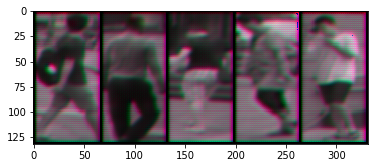

In [22]:
#%debug
g1.cuda()

dd.cuda()

use_gpu = torch.cuda.is_available()
print_every = 1000

criterion = nn.BCELoss() #nn.MultiLabelSoftMarginLoss

#g1_opt = optim.Adam(g1.parameters(), lr=2e-5, betas=(0.5, 0.999), eps=1e-08, weight_decay=1e-3)
g1_opt = optim.Adam(g1.parameters(), lr=2e-5, betas=(0.5, 0.999), eps=1e-08, weight_decay=0)
d_opt = optim.Adam(dd.parameters(), lr=2e-5, betas=(0.5, 0.999), eps=1e-08, weight_decay=0)


#train_g1(g1, num_epochs=1)

train_g1_d(g1,dd,num_epochs=1)

Epoch 0/0
----------
train



1.00000e-02 *
  2.9806
[torch.FloatTensor of size 1]

val



1.00000e-02 *
  3.1421
[torch.FloatTensor of size 1]


Training complete in 606m 27s


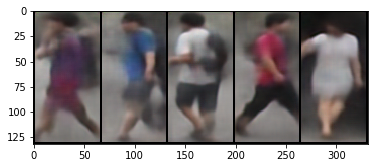

In [21]:
#%debug
"""
g1.cuda()


use_gpu = torch.cuda.is_available()
print_every = 1000

criterion = nn.BCELoss() #nn.MultiLabelSoftMarginLoss

g1_opt = optim.Adam(g1.parameters(), lr=2e-5, betas=(0.5, 0.999), eps=1e-08, weight_decay=0)

#g1_opt = optim.Adadelta(g1.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)


train_g1(g1,num_epochs=1)
"""

In [23]:

randListPath = '/home/dsp411/zhou/MYwork2/save_model/rnd_black.npy'
np.save(randListPath,np.array(randList))
#np.save(HeatmapForder+fname[:-4]+'_heat.npy',heatMap)

g1_PATH = '/home/dsp411/zhou/MYwork2/save_model/g1_black.pth'
torch.save(g1.state_dict(), g1_PATH)

In [24]:
def train_model(generator1,generator2,discriminator, num_epochs=25):
    since = time.time()


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        photo = torch.zeros(5,3,128,64)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                discriminator.train(True)  # Set model to evaluate mode
                generator1.train(False)  # Set model to evaluate mode
                generator2.train(True)  # Set model to evaluate mode
                dst_loader = loader_train
                dset_sizes =len(train_data)
            else:
                #pdb.set_trace()
                discriminator.train(False)  # Set model to evaluate mode
                generator1.train(False)  # Set model to evaluate mode
                generator2.train(False)  # Set model to evaluate mode
                dst_loader = loader_val
                dset_sizes =len(val_data)
                showone = np.random.randint(dset_sizes/10, size=1)[0]

            D_loss = 0.0
            G2_loss = 0.0
            D_corrects =0.0
            G_corrects =0.0

            
            for t, datas in enumerate(dst_loader):

                imagesA, imagesB,heatMapB,maskB,labels = datas
                
                imagesA = Variable(imagesA).cuda()
                imagesB = Variable(imagesB).cuda()
                heatMap = Variable(heatMap).cuda()
                mask = Variable(mask).cuda()

                
                real_labels = Variable(torch.ones(imagesA.size(0))).cuda()
                fake_labels = Variable(torch.zeros(imagesA.size(0))).cuda()


             
                IaHb = torch.cat((imagesA,heatMapB),1)
                fake_images1 = generator1(IaHb)
                    
                # Train the g2
                g2_opt.zero_grad()
                
                IaF1b = torch.cat((imagesA,fake_images1.detach()),1)
                fake_images2 = generator2(IaF1b)
                
                if phase == 'val':
                    if t == showone:
                        photo = fake_images2.data.cpu()
                      
                fakePair = torch.cat((imagesA,fake_images2),1)
                
                outputs = discriminator(fakePair.detach()) 
                g_corrects = torch.sum(outputs)
                
                g2_loss = criterion(outputs, real_labels)\
                    + 1*( Mask_pairwise_distance(fake_images2,imagesB,mask,p=1) )

                if phase == 'train':
                    g2_loss.backward()
                    g2_opt.step()
                
                # Train the dd real
                d_opt.zero_grad()
                imagePair = torch.cat((imagesA,imagesB),1)
                outputs = discriminator(imagePair)
                real_loss = criterion(outputs, real_labels)
                real_score = torch.sum(outputs)

                # Train the dd fake
                outputs = discriminator(fakePair.detach()) 
                fake_loss = criterion(outputs, fake_labels)
                fake_score = outputs

                d_loss = real_loss + fake_loss
                
                if phase == 'train':
                    d_loss.backward()
                    d_opt.step()
                

                
                g_corrects = outputs
            

                
                D_loss  += d_loss.data.cpu()
                G2_loss += g2_loss.data.cpu()
                D_corrects += real_score.data.cpu()
                G_corrects += g_corrects.data.cpu()
            

                
                #classify_acc += torch.sum(label_preds1 == label1.data.cuda())
            
            epoch_D_loss = D_loss / dset_sizes
            epoch_G2_loss = G2_loss / dset_sizes
            
            epoch_D_corrects = D_corrects / dset_sizes
            epoch_G_corrects = G_corrects / dset_sizes


            

            print(phase)
            print("\n")

            print( epoch_D_loss,epoch_G2_loss,epoch_D_corrects,epoch_G_corrects )

        imshow(torchvision.utils.make_grid(photo))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return 

Epoch 0/0
----------
train



1.00000e-03 *
  2.2769
[torch.FloatTensor of size 1]
 
 434.1792
[torch.FloatTensor of size 1]
 
 0.9966
[torch.FloatTensor of size 1]
 
1.00000e-04 *
  6.7352
  6.7506
  6.7388
  6.3934
  6.7548
[torch.FloatTensor of size 5x1]

val



 0.1088
[torch.FloatTensor of size 1]
 
 788.9555
[torch.FloatTensor of size 1]
 
 0.9186
[torch.FloatTensor of size 1]
 
1.00000e-02 *
  6.9227
  6.9390
  6.9318
  6.9365
  6.9410
[torch.FloatTensor of size 5x1]


Training complete in 470m 44s


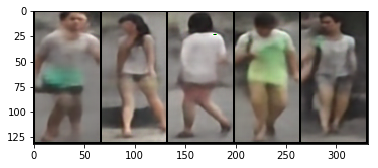

In [23]:
#%debug
g1.cuda()
g2.cuda()
dd.cuda()

use_gpu = torch.cuda.is_available()
print_every = 1000

criterion = nn.BCELoss() #nn.MultiLabelSoftMarginLoss

#g1_opt = optim.Adam(g1.parameters(), lr=2e-5, betas=(0.5, 0.999), eps=1e-08, weight_decay=1e-3)
g2_opt = optim.Adam(g2.parameters(), lr=2e-5, betas=(0.5, 0.999), eps=1e-08, weight_decay=0)
d_opt = optim.Adam(dd.parameters(), lr=2e-5, betas=(0.5, 0.999), eps=1e-08, weight_decay=0)




train_model(g1,g2,dd,num_epochs=1)


In [24]:
"""
#g1_PATH = '/home/dsp411/zhou/MYwork2/save_model/g1_good.pth'
#torch.save(g1.state_dict(), g1_PATH)
g2_PATH = '/home/dsp411/zhou/MYwork2/save_model/g2_good.pth'
torch.save(g2.state_dict(), g2_PATH)
dd_PATH = '/home/dsp411/zhou/MYwork2/save_model/dd_good.pth'
torch.save(dd.state_dict(), dd_PATH)
"""

In [18]:
g1_PATH = '/home/dsp411/zhou/MYwork2/save_model/g1_35.pth'
g1.load_state_dict( torch.load(g1_PATH) )

g2_PATH = '/home/dsp411/zhou/MYwork2/save_model/g2_35.pth'
g2.load_state_dict( torch.load(g2_PATH) )

dd_PATH = '/home/dsp411/zhou/MYwork2/save_model/dd_35.pth'
dd.load_state_dict( torch.load(dd_PATH) )

In [25]:
def make_sample_dataset(dir,randomList,junk,class_to_idx):

    datas = []
    labels = []
    cams = []


    file_list = sorted(os.listdir(dir))
    
    for i in randomList:
        fname = file_list[i]
        if is_image_file(fname) and fname not in junk:
            #path = os.path.join(dir, fname)
            label = class_to_idx[ int(fname[:-19]) ] 
            cam = int(fname[-17:-16])
            datas.append(fname)
            labels.append(label)
            cams.append(cam)
            



    return datas,labels,cams

In [26]:
class poseSampler(data.Dataset):
    """From the MNIST Dataset it generates triplet samples
    note: a triplet is composed by a pair of matching images and one of
    different class.
    """
    
    def __init__(self, root, root2, randomList, names,n_pairs=800, transform=None, target_transform=None,
                 loader=default_loader ):
        
        self.classes,self.class_to_idx, self.idx_to_class = find_classes(root)
        
        self.nameList = self.getNameList(names)
        
        self.datas, self.labels, self.cams = make_sample_dataset(root,randomList,self.nameList,self.class_to_idx)
        
        if len(self.datas) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

        self.root = root
        self.root2 = root2
        
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

        self.n_pairs =n_pairs


        self.pairs = self.get_pairs(self.labels)

            
    def getNameList(self,names):
        import scipy.io

        mat = scipy.io.loadmat(names)

        nameList =[]
        for i in range(len(mat['filelist'][0])):
            bb = mat['filelist'][0][i][0]
            dd = str(bb.tolist())
            nameList.append(dd[:-9]+'.jpg')
        return nameList
            


    def get_pairs(self,labels):
        pairs = []
        labels = np.asarray(labels)
        ulabels = np.unique(labels)
        #ulabels = self.classes
        matches, no_matches = dict(), dict()
   
        for x in ulabels:

            no_matches[x] = np.where(labels != x)[0]

            
        temp = np.random.choice(ulabels,self.n_pairs)

        #set_trace()
        for x in temp:

            if no_matches[x].shape[0] < 2:
                idx_a, idx_b = np.random.choice(no_matches[x], 2)
            else:
                idx_a, idx_b = np.random.choice(no_matches[x], 2, replace=False)

            pairs.append([idx_a, idx_b])
        
        return np.array(pairs)
    
    

    def __getitem__(self, index):        

            
        t = self.pairs[index]
        a, b = self.datas[t[0]], self.datas[t[1]]


        label = self.labels[t[1]]


        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        imPathA = self.root + a 
        imPathB = self.root + b 

        heatPath = self.root2 + 'train_heatmap/' + b[:-4] + '_heat.npy'
        maskPath = self.root2 + 'train_mask/' + b[:-4] + '_mask.png'

        img_a = self.loader(imPathA)
        img_b = self.loader(imPathB)
        heat = numpy_loader(heatPath)
        mask = self.loader(maskPath)




        if self.transform is not None:
            img_a = self.transform(img_a)
            img_b = self.transform(img_b)

        mask = self.transform(mask)


        heat = np.transpose(heat, (2,0,1))  
        heat = torch.from_numpy(heat[:18])

        #pdb.set_trace()

        return img_a, img_b, heat, mask, label
        
  

    def __len__(self):

        return self.pairs.shape[0]


In [27]:
#%debug
import random
randList = list(range(12937))
random.shuffle(randList)
market = '/home/dsp411/zhou/datasets/market/Market-1501-v15.09.15/bounding_box_train/'
names ='/home/dsp411/zhou/MYwork2/pytorch_Realtime_Multi-Person_Pose_Estimation-master/sample_image/filenames.mat'
root2 = '/home/dsp411/zhou/MYwork2/pytorch_Realtime_Multi-Person_Pose_Estimation-master/sample_image/'
trans_TEST = transforms.Compose([
        #myreScale(240),
        #myRandomSizedCrop(224),
        #T.RandomHorizontalFlip(),
        T.ToTensor()
])

my_trans = transforms.Compose([
        myRandomSizedCrop((115,58)),
        T.RandomHorizontalFlip(),
        T.ToTensor()]

        
)


sample_data = poseSampler(market,root2,randList,names,n_pairs=100,transform=trans_TEST)
sample_class_idx = sample_data.class_to_idx
sample_len = len(sample_data)
loader_sample = DataLoader(sample_data,batch_size=1)





torch.Size([1, 3, 128, 64])

 572
[torch.LongTensor of size 1]



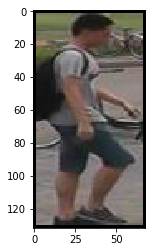

In [28]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def imshow(img):
    #img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
def imsave(PATH,img):
    #img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imsave(PATH,np.transpose(npimg, (1,2,0)))

# show some random training images
dataiter = iter(loader_sample)
imagesA, imagesB,heatMap,mask,labels = dataiter.next()

# print images
print(imagesA.size())

imshow(torchvision.utils.make_grid(imagesA))
#imshow(torchvision.utils.make_grid(heatMap[:,17,:,:]))

print(labels)
#filename = root2+'abc'
#imsave(filename, torch.squeeze(imagesA))



In [29]:
def sample_model(generator1,generator2,PATH, num_photo=20,):
    
    since = time.time()


    # Each epoch has a training and validation phase

    dst_loader = loader_sample
    dset_sizes =len(train_data)


    generator1.train(False)  # Set model to evaluate mode
    generator2.train(False)  # Set model to evaluate mode

    #photos = torch.Tensor(num_photo,6,128,64)
    index=0
    
            
    for t, datas in enumerate(dst_loader):
        if t ==num_photo:
            return
        imagesA, imagesB,heatMapB,maskB,labelsA = datas
        batch = imagesA.size(0)

        imagesA = Variable(imagesA).cuda()
        imagesB = Variable(imagesB).cuda()
        heatMapB = Variable(heatMapB).cuda()
        maskB = Variable(maskB).cuda()


        IaHb = torch.cat((imagesA,heatMapB),1)
        fake_images1 = generator1(IaHb)

        #IaF1b = torch.cat((imagesA,fake_images1.detach()),1)
        #fake_images2 = generator2(IaF1b)


        imsave(PATH+str(t) +'a.png',torch.squeeze(imagesA.data.cpu()))
        imsave(PATH+str(t)+'b.png',torch.squeeze(fake_images1.data.cpu()))
        print(t)



    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return 

In [30]:
#%debug
PATH = "/home/dsp411/zhou/MYwork2/pytorch_Realtime_Multi-Person_Pose_Estimation-master/sample_image/black/"
sample_model(g1,g2, PATH,num_photo=100)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Training complete in 0m 3s
